# Recurrent Neural Networks

The 4th task is about classification *on tabular data*. What if the approach was wrong? What would happen if we changed the nature of the data?

This notebook revolves around using models for time series to tackle the classification task of the Data Mining project. However, these models shouldn't be compared with those that make use of tabular data, as the validation set will be different, and the data it uses is inherently different. Is still part of task 4 in a sense...

Maybe I'll write a better introduction for this, for now let's move on.

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

As usual, we import all the packages and stuff

In [2]:
import procyclingstats as pcs
# Base libraries
import os
import sys
# Basic data manipulation libraries
import numpy as np
import pandas as pd
import itertools
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))

Import from our own utilities

In [3]:
from utility.classification_utility import make_dataset_for_RNN_classification, TO_NOT_USE_COLS, TO_REMOVE_COLS

Other constants, global variables

In [4]:
IMAGES_DIR = os.path.join('Images', 'Clustering_imgs', 'recurrent_models_imgs')

RACES_URL = os.path.join('..', 'dataset', 'races_cleaned.csv')
CYCLISTS_URL = os.path.join('..', 'dataset', 'cyclists_cleaned.csv')

# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = False

VAL_PROPORTION = 0.1

## Dataset Creation

As said, the creation of the dataset is not trivial at all.

In [5]:
merged = make_dataset_for_RNN_classification(cyclists_path=CYCLISTS_URL, races_path=RACES_URL)
merged.shape

(523073, 30)

The cell above takes a long time to run. That's because there's a lot going on

The `make_dataset_for_RNN_classification` removes some more columns:
- `time_seconds`: is just the conversion of the `time` column from string into the n° of seconds (int). With the `timedelta64[s]` datatype, this is not necessary
- `cyclist_age_cyc`: is just `2024 - birth_year` (2024 because it was created last year)

In [6]:
merged.head()

_url_rac  \
cyclist                                                      
aad-van-den-hoek 72148        tour-de-suisse/1975/stage-9b   
                 398199           paris-nice/1976/prologue   
                 408882  omloop-het-nieuwsblad/1977/result   
                 441142  omloop-het-nieuwsblad/1978/result   
                 56937        tour-de-france/1978/prologue   

                                         name_rac     stage stage_type  \
cyclist                                                                  
aad-van-den-hoek 72148             Tour de Suisse  stage-9b        ITT   
                 398199              Paris - Nice  prologue         RR   
                 408882  Omloop Het Nieuwsblad ME       NaN         RR   
                 441142  Omloop Het Nieuwsblad ME       NaN         RR   
                 56937             Tour de France  prologue         RR   

                         points  uci_points    length  climb_total  profile  \
cyclist                                                                       
aad-van-den-hoek 72148      7.0         0.0   20400.0          NaN      NaN   
                 398199     0.0         0.0    6500.0          NaN      NaN   
                 408882     0.0         0.0  201000.0          NaN      NaN   
                 441142     0.0         0.0  218000.0          NaN      NaN   
                 56937      0.0         0.0    5200.0         27.0      1.0   

                         startlist_quality  ... race_country  \
cyclist                                     ...                
aad-van-den-hoek 72148                 549  ...  Switzerland   
                 398199                779  ...       France   
                 408882                595  ...      Belgium   
                 441142                493  ...      Belgium   
                 56937                1241  ...       France   

                         age_performance_index  stamina_index  birth_year  \
cyclist                                                                     
aad-van-den-hoek 72148              -21.241584            NaN      1951.0   
                 398199                    NaN            NaN      1951.0   
                 408882                    NaN            NaN      1951.0   
                 441142                    NaN            NaN      1951.0   
                 56937                     NaN       0.242968      1951.0   

                        weight height  nationality        bmi  \
cyclist                                                         
aad-van-den-hoek 72148    77.0  186.0  Netherlands  22.256908   
                 398199   77.0  186.0  Netherlands  22.256908   
                 408882   77.0  186.0  Netherlands  22.256908   
                 441142   77.0  186.0  Netherlands  22.256908   
                 56937    77.0  186.0  Netherlands  22.256908   

                         partecipants_number  target  
cyclist                                               
aad-van-den-hoek 72148                     6    True  
                 398199                   15    True  
                 408882                   38   False  
                 441142                   31   False  
                 56937                   110   False  

[5 rows x 30 columns]

We notice that the `cyclist` column has now become an index. In fact the `make_dataset_for_RNN_classification`
- **Groups** the rows by cyclist, in order to put together the records of the same cyclist, to create time series of the cyclists
- **Sorts** the rows by date, inside each group
- ~~**Shifts** some columns~~

Let's check that all dates are sorted

In [7]:
all_sorted = True
for cyclist in merged.index.levels[0]:
	truth = merged.loc[cyclist, 'date'].is_monotonic_increasing
	if not truth:
		print(f"For {cyclist}, dates are not sorted")
		all_sorted = False

if all_sorted:
	print("All dates are sorted")

All dates are sorted


In [8]:
merged.columns

Index(['_url_rac', 'name_rac', 'stage', 'stage_type', 'points', 'uci_points',
       'length', 'climb_total', 'profile', 'startlist_quality', 'date',
       'position', 'cyclist_age_rac', 'is_tarmac', 'delta', 'time',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'age_performance_index', 'stamina_index', 'birth_year', 'weight',
       'height', 'nationality', 'bmi', 'partecipants_number', 'target'],
      dtype='object')

There are a sh*t ton of columns now. And we're not even done yet. I don't like it, but it is what it is.

### Data Selection

Un ripasso, per me ([x] vuol dire che l'ho messa):
- Da **buttare di sicuro**
  - `_url_rac`, 
  - `quality_adjusted_points` se già non viene rimossa. 
  - `age_performance_index`, `age_performance_index_shifted`la RNN sarà più intelligente di una moltiplicazione. E poi sta feature mi ha rotto i cosiddetti
  - `is_tarmac` per piacere	
  - `birth_year`, perché tanto un ciclista che ha NaN come `cyclist_age` ha sicuramente anche NaN come `birth_year`, ma il viceversa è falso. Ovvero, mantenendo `cyclist_age_rac` manteniamo le stesse informazioni di `birth_year` e anche qualcosa in più
- Da **tenere di sicuro**:
  - [x] `length`, `climb_total`, `startlist_quality`, `cyclist_age_rac`, `steepness`, `weigth`, `heigth`, `partecipants_number`
  - [x] `delta_shifted`, `time_shifted`, `position_shifted`, `points_shifted`, `average_speed_shifted`
- Da **buttare forse**:
  - `stamina_index`, `stamina_index_shifted`, `bmi`, in quanto funzioni delle altre features
  - `name_rac`, `stage`
  - `date` Probabilmente è solo un indice. Possiamo estrarre l'anno forse?
- Da **non usare per allenare le RNN**:
  - `delta`, `stamina_index`, `points`, `uci_points`, `average_speed`, `position`, `time`
  - `target` (ovviamente)
- Da **one-hot encodeare forse**:
  - [x] `race_country` (8 valori e nan)
  - [] `name_rac` (27 valori). Se si codifica questa possiamo evitare di codificare quella prima
  - [] `season` (4 valori)
  - [x] `nationality` (73 valori!!!)
  - [x] `stage_type` (2 valori), forse non è una gran feature
- Da **one-hot encodeare di sicuro**:
  - [x] `profile` (5 valori e nan)
  - [x] `is_staged` (2 valori)

Well, something can be done.

In [9]:
merged['is_staged'] = merged['is_staged'].astype(float)
# We encode the NaNs in the profile as -1
merged['profile'] = merged['profile'].astype(float).fillna(-1)
# Rename the stage_type column to is_ITT
merged.rename(columns={'stage_type': 'is_ITT'}, inplace=True)
merged['is_ITT'] = merged['is_ITT'].apply(lambda x: 1. if x == 'ITT' else 0.)

In [10]:
TO_USE_COLS = [
	## race related
	'length', 'climb_total', 'steepness',
	'startlist_quality', 'partecipants_number',
	'cyclist_age_rac',
	'profile', 'is_staged',
	'is_ITT', # not sure about keeping this
	## cyclist related
	'weigth', 'heigth',
	## the shifted features
	'delta_shifted', 'time_shifted',
	'position_shifted', 'average_speed_shifted',
	'points_shifted',
	## maybe encode
	'nationality', 'race_country',
	#'name_rac', We'll use this feature for further manipulations
]

### Isolationg Training set and Test set

Before we do anything else, let's isolate the test set. Altrimenti il Micheli arriva e ci picchia.

In [11]:
merged['date'] >= '2022-01-01'

cyclist                 
aad-van-den-hoek  72148     False
                  398199    False
                  408882    False
                  441142    False
                  56937     False
                            ...  
zoran-klemencic   456303    False
                  206264    False
                  270468    False
                  347100    False
zsolt-der         303113    False
Name: date, Length: 523073, dtype: bool

In [12]:
dev_data = merged[merged['date'] < '2022-01-01']
ts_data = merged[merged['date'] >= '2022-01-01']

print(f"Dev  set earlier date: {dev_data['date'].min()}, latest date: {dev_data['date'].max()}")
print(f"Test set earlier date: {ts_data['date'].min()}, latest date: {ts_data['date'].max()}")
print()
print(f"Dev  set shape: {dev_data.shape}, i.e. {100*dev_data.shape[0]/merged.shape[0]:>5.2f}% of the data") 
print(f"Test set shape:  {ts_data.shape}, i.e. {100*ts_data.shape[0]/merged.shape[0]:>5.2f}% of the data")
print()
print(f"In terms of actual samples, there are {dev_data.index.get_level_values(0).nunique()} time series in the Dev set, i.e. {100*dev_data.index.get_level_values(0).nunique()/merged.index.get_level_values(0).nunique():>5.2f}% of the total")
print(f"In terms of actual samples, there are {ts_data.index.get_level_values(0).nunique()} time series in the Test set, i.e. {100*ts_data.index.get_level_values(0).nunique()/merged.index.get_level_values(0).nunique():>5.2f}% of the total")
print("(Keep in mind that the data doesn't overlap, but the cyclists do)")

Dev  set earlier date: 1970-02-28 00:00:00, latest date: 2021-10-09 00:00:00
Test set earlier date: 2022-02-21 00:00:00, latest date: 2023-07-29 00:00:00

Dev  set shape: (492644, 30), i.e. 94.18% of the data
Test set shape:  (30429, 30), i.e.  5.82% of the data

In terms of actual samples, there are 5764 time series in the Dev set, i.e. 94.91% of the total
In terms of actual samples, there are 1006 time series in the Test set, i.e. 16.57% of the total
(Keep in mind that the data doesn't overlap, but the cyclists do)


In this split is almost certain that some cyclists appear both in the training and in the test set, but with different data. Again, it is what it is. What's important is to respect the golden rule, otherwise Micheli arrives and steals all of our Buccellato

We need a validation set to tune our precious hyperparameters. Since our data is time series data, it is only natural that we choose some cyclists as validation data.

I'm lazy and poor, I have an Nvidia GPU but don't tell anyone. On the other hand, data is plentiful. Therefore I just hold out some of the data for validation. No K-folds, no fancy stuff. Via su che sono quelle facce. Dai, non fatemi sentire in colpa.

We randomly select a portion of the development set data, uniformly over the `birth_years` of the cyclists. We do this because we want to be "translation invariant". I mean, we want our recurrent models to capture a behaviour that generalizes over time. The assumption being that cyclism is cyclism, regardless of the year.

In [64]:
dev_cyc_and_date = dev_data.groupby('cyclist')['birth_year'].first()
dev_cyc_and_date = dev_cyc_and_date.to_frame().reset_index()
dev_cyc_and_date['birth_year_bin'] = pd.cut(dev_cyc_and_date['birth_year'], bins=range(int(dev_cyc_and_date['birth_year'].min()), int(dev_cyc_and_date['birth_year'].max()), 5), right=False)
#dev_cyc_and_date['birth_year_bin'].value_counts().sort_index()

In [65]:
val_indices = dev_cyc_and_date.groupby('birth_year').apply(lambda x: x.sample(frac=VAL_PROPORTION, random_state=RANDOM_STATE), include_groups=False).index
val_indices_mk2 = dev_cyc_and_date.groupby('birth_year_bin',observed=True).apply(lambda x: x.sample(frac=VAL_PROPORTION, random_state=RANDOM_STATE), include_groups=False).index

In [79]:
val_indices

MultiIndex([(1939.0, 1232),
            (1940.0,  531),
            (1940.0, 4614),
            (1941.0,  458),
            (1941.0, 1892),
            (1942.0, 1975),
            (1942.0, 3330),
            (1942.0,   36),
            (1943.0, 5325),
            (1943.0, 5654),
            ...
            (1998.0, 4767),
            (1998.0,  936),
            (1998.0,  396),
            (1999.0, 5365),
            (1999.0, 3850),
            (1999.0, 3885),
            (1999.0, 5350),
            (2000.0,    9),
            (2000.0,  630),
            (2001.0,  553)],
           names=['birth_year', None], length=577)

In [60]:
val_indices_mk2

MultiIndex([([1933, 1938), 2143),
            ([1938, 1943),  531),
            ([1938, 1943), 4850),
            ([1938, 1943), 1759),
            ([1938, 1943),   36),
            ([1938, 1943), 2027),
            ([1938, 1943), 5689),
            ([1938, 1943), 1243),
            ([1943, 1948), 5649),
            ([1943, 1948), 1721),
            ...
            ([1993, 1998), 5378),
            ([1993, 1998), 5302),
            ([1993, 1998),  935),
            ([1993, 1998), 4783),
            ([1993, 1998), 3171),
            ([1993, 1998), 3173),
            ([1993, 1998), 5668),
            ([1993, 1998), 1365),
            ([1993, 1998), 5495),
            ([1993, 1998), 3085)],
           names=['birth_year_bin', None], length=561)

In [38]:
val_counts_mk2 = val_indices_mk2.get_level_values(0).value_counts().sort_index()
val_counts_mk2

birth_year_bin
[1933, 1938)     1
[1938, 1943)     7
[1943, 1948)    23
[1948, 1953)    29
[1953, 1958)    38
[1958, 1963)    57
[1963, 1968)    60
[1968, 1973)    61
[1973, 1978)    64
[1978, 1983)    64
[1983, 1988)    60
[1988, 1993)    52
[1993, 1998)    45
Name: count, dtype: int64

In [74]:
dev_data.index

MultiIndex([('aad-van-den-hoek',  72148),
            ('aad-van-den-hoek', 398199),
            ('aad-van-den-hoek', 408882),
            ('aad-van-den-hoek', 441142),
            ('aad-van-den-hoek',  56937),
            ('aad-van-den-hoek', 224535),
            ('aad-van-den-hoek', 154160),
            ('aad-van-den-hoek', 424412),
            ('aad-van-den-hoek',  29279),
            ('aad-van-den-hoek', 350161),
            ...
            ( 'zoran-klemencic', 452928),
            ( 'zoran-klemencic', 367898),
            ( 'zoran-klemencic', 298910),
            ( 'zoran-klemencic',  66747),
            ( 'zoran-klemencic', 153510),
            ( 'zoran-klemencic', 456303),
            ( 'zoran-klemencic', 206264),
            ( 'zoran-klemencic', 270468),
            ( 'zoran-klemencic', 347100),
            (       'zsolt-der', 303113)],
           names=['cyclist', None], length=492644)

In [88]:
dev_data

_url_rac  \
cyclist                                                      
aad-van-den-hoek 72148        tour-de-suisse/1975/stage-9b   
                 398199           paris-nice/1976/prologue   
                 408882  omloop-het-nieuwsblad/1977/result   
                 441142  omloop-het-nieuwsblad/1978/result   
                 56937        tour-de-france/1978/prologue   
...                                                    ...   
zoran-klemencic  456303        giro-d-italia/2004/stage-10   
                 206264        giro-d-italia/2004/stage-11   
                 270468        giro-d-italia/2004/stage-12   
                 347100        giro-d-italia/2004/stage-13   
zsolt-der        303113     world-championship/2010/result   

                                                name_rac     stage  is_ITT  \
cyclist                                                                      
aad-van-den-hoek 72148                    Tour de Suisse  stage-9b     1.0   
                 398199                     Paris - Nice  prologue     0.0   
                 408882         Omloop Het Nieuwsblad ME       NaN     0.0   
                 441142         Omloop Het Nieuwsblad ME       NaN     0.0   
                 56937                    Tour de France  prologue     0.0   
...                                                  ...       ...     ...   
zoran-klemencic  456303                    Giro d'Italia  stage-10     0.0   
                 206264                    Giro d'Italia  stage-11     0.0   
                 270468                    Giro d'Italia  stage-12     0.0   
                 347100                    Giro d'Italia  stage-13     1.0   
zsolt-der        303113  World Championships - Road Race       NaN     0.0   

                         points  uci_points    length  climb_total  profile  \
cyclist                                                                       
aad-van-den-hoek 72148      7.0         0.0   20400.0          NaN     -1.0   
                 398199     0.0         0.0    6500.0          NaN     -1.0   
                 408882     0.0         0.0  201000.0          NaN     -1.0   
                 441142     0.0         0.0  218000.0          NaN     -1.0   
                 56937      0.0         0.0    5200.0         27.0      1.0   
...                         ...         ...       ...          ...      ...   
zoran-klemencic  456303     0.0         0.0  146000.0       2215.0      2.0   
                 206264     0.0         0.0  228000.0       2401.0      2.0   
                 270468    25.0         0.0  210000.0        171.0      1.0   
                 347100     0.0         0.0   52000.0        753.0      2.0   
zsolt-der        303113    15.0         0.0  262700.0       2492.0     -1.0   

                         startlist_quality  ... race_country  \
cyclist                                     ...                
aad-van-den-hoek 72148                 549  ...  Switzerland   
                 398199                779  ...       France   
                 408882                595  ...      Belgium   
                 441142                493  ...      Belgium   
                 56937                1241  ...       France   
...                                    ...  ...          ...   
zoran-klemencic  456303                621  ...        Italy   
                 206264                621  ...        Italy   
                 270468                621  ...        Italy   
                 347100                621  ...        Italy   
zsolt-der        303113               1307  ...          NaN   

                         age_performance_index  stamina_index  birth_year  \
cyclist                                                                     
aad-van-den-hoek 72148              -21.241584            NaN      1951.0   
                 398199                    NaN            NaN      1951.0   
                 408882                    NaN            N

In [39]:
[x.mid for x in val_counts_mk2.index]

[1935.5,
 1940.5,
 1945.5,
 1950.5,
 1955.5,
 1960.5,
 1965.5,
 1970.5,
 1975.5,
 1980.5,
 1985.5,
 1990.5,
 1995.5]

In [42]:
val_counts_mk2.index

CategoricalIndex([[1933, 1938), [1938, 1943), [1943, 1948), [1948, 1953),
                  [1953, 1958), [1958, 1963), [1963, 1968), [1968, 1973),
                  [1973, 1978), [1978, 1983), [1983, 1988), [1988, 1993),
                  [1993, 1998)],
                 categories=[[1933, 1938), [1938, 1943), [1943, 1948), [1948, 1953), ..., [1978, 1983), [1983, 1988), [1988, 1993), [1993, 1998)], ordered=True, dtype='category', name='birth_year_bin')

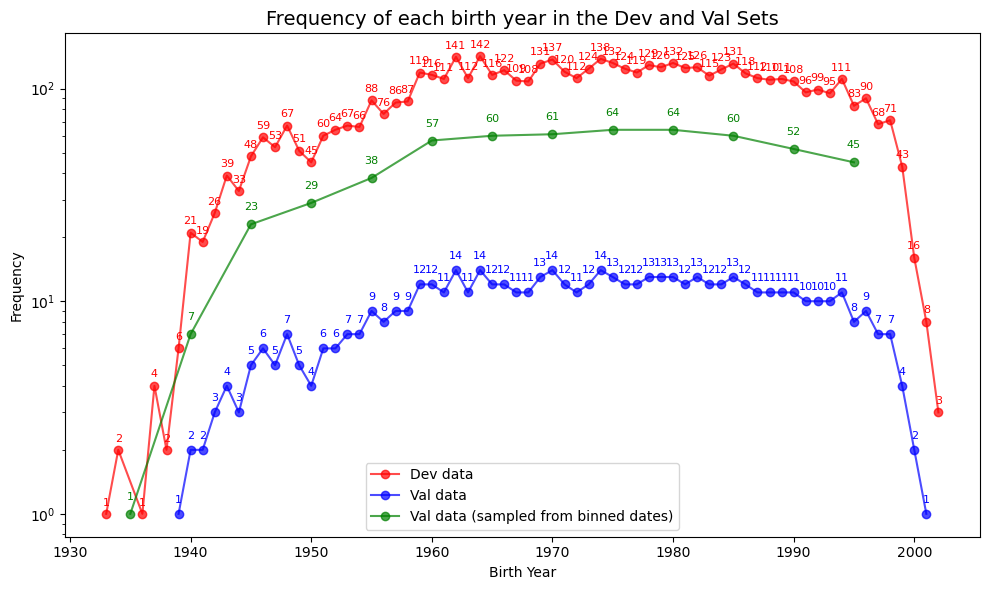

In [68]:
plt.figure(figsize=(10, 6))

dev_counts = dev_cyc_and_date['birth_year'].value_counts().sort_index()
val_counts = val_indices.get_level_values(0).value_counts().sort_index()
val_counts_mk2 = val_indices_mk2.get_level_values(0).value_counts().sort_index()

# Convert Interval index to string
val_counts_mk2.index = [int(x.mid) for x in val_counts_mk2.index]

plt.plot(dev_counts, marker='o', color='red', alpha=0.7, label='Dev data')
plt.plot(val_counts, marker='o', color='blue', alpha=0.7, label='Val data')
plt.plot(val_counts_mk2, marker='o', color='green', alpha=0.7, label='Val data (sampled from binned dates)')

for x, y in dev_counts.items():
	plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8, color='red')

for x, y in val_counts.items():
	plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=8, color='blue')

for x, y in val_counts_mk2.items():
	plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')

plt.xlabel('Birth Year')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Frequency of each birth year in the Dev and Val Sets', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
val_data = dev_data.reset_index()
val_data = val_data[val_data['level_1'].isin(val_indices_mk2.get_level_values(1))]
val_data.set_index(['cyclist', 'level_1'], inplace=True)
val_data.index.names = ['cyclist', None]
val_data

_url_rac  \
cyclist                                                       
aad-van-den-hoek      794      tour-de-france/1978/stage-14   
                      4862     tour-de-france/1981/stage-15   
                      920   volta-a-catalunya/1981/stage-2b   
aart-vierhouten       5638         e3-harelbeke/2002/result   
abraham-olano-manzano 4103     tour-de-france/1997/stage-15   
...                                                     ...   
youcef-reguigui       5205    la-fleche-wallone/2015/result   
yvon-bertin           792      tour-de-france/1978/stage-14   
                      4482      tour-de-france/1981/stage-2   
zbigniew-spruch       4595   tirreno-adriatico/1999/stage-4   
zhandos-bizhigitov    5082      giro-d-italia/2017/stage-15   

                                              name_rac     stage  is_ITT  \
cyclist                                                                    
aad-van-den-hoek      794               Tour de France  stage-14     1.0   
                      4862              Tour de France  stage-15     0.0   
                      920   Volta Ciclista a Catalunya  stage-2b     0.0   
aart-vierhouten       5638        E3 BinckBank Classic       NaN     0.0   
abraham-olano-manzano 4103              Tour de France  stage-15     0.0   
...                                                ...       ...     ...   
youcef-reguigui       5205          La Flèche Wallonne       NaN     0.0   
yvon-bertin           792               Tour de France  stage-14     1.0   
                      4482              Tour de France   stage-2     0.0   
zbigniew-spruch       4595           Tirreno-Adriatico   stage-4     0.0   
zhandos-bizhigitov    5082               Giro d'Italia  stage-15     0.0   

                            points  uci_points    length  climb_total  \
cyclist                                                                 
aad-van-den-hoek      794      0.0         0.0   52000.0       1351.0   
                      4862     0.0         0.0  231000.0       4000.0   
                      920     50.0         0.0   30000.0          NaN   
aart-vierhouten       5638     0.0         0.0  209000.0          NaN   
abraham-olano-manzano 4103     8.0         0.0  208500.0       5000.0   
...                            ...         ...       ...          ...   
youcef-reguigui       5205     5.0         0.0  205500.0       3030.0   
yvon-bertin           792      0.0         0.0   52000.0       1351.0   
                      4482     0.0         0.0  254000.0       3500.0   
zbigniew-spruch       4595     0.0         0.0  197000.0          NaN   
zhandos-bizhigitov    5082     0.0         0.0  199000.0       2255.0   

                            profile  startlist_quality  ... race_country  \
cyclist                                                 ...                
aad-van-den-hoek      794       5.0               1241  ...       France   
                      4862      4.0               1362  ...       France   
                      920      -1.0                388  ...        Spain   
aart-vierhouten       5638      2.0                400  ...      Belgium   
abraham-olano-manzano 4103      4.0               1994  ...       France   
...                             ...                ...  ...          ...   
youcef-reguigui       5205      3.0               1112  ...      Belgium   
yvon-bertin           792       5.0               1241  ...       France   
                      4482      1.0               1362  ...       France   
zbigniew-spruch       4595     -1.0               1150  ...        Italy   
zhandos-bizhigitov    5082      2.0                881  ...        Italy   

                            age_performance_index  stamina_index  birth_year  \
cyclist                                                                        
aad-van-den-hoek      794                     NaN       1.911180      1951.0   
                      4862                    NaN       9.58149

---

### Columns shifting

Now that we've isolated training and test set we can **shift** columns

A few more words on the columns shifting.

For the tabular data models we can't use some of the columns' values, we can just use the past values to compute the current prediction. For example, we can't use the current value for the `position` feature to predict if the cyclist is in the top 20, but we can use all the past values as we see fit.

In the exploration, we identified features such as `average_position` that make use of these "forbidden values", as they make use of all the data available. Thus, they have to be computed for each timestep. For example, each record of a cyclist has the `average_position` value it had at the point of his career that corresponds to this record, excluding the current `position` value.

In this way, classifiers based on tabular data can make use of these weird features.

Well, for sequence models we don't need these summarizations. We leave it to the model to use all the values of the sequence seen so far, for its training, sa it sees fit. The only thing we have to make sure is to not use the current one. Hence the column shifting.

Let's check that the shift is successful

In [ ]:
def inefficient_comparer(l1:pd.Series, l2:pd.Series) -> bool:
	"""Compares two series (inefficiently), to take into account the NaNs"""
	for i, j in zip(l1, l2):
		if (pd.isna(i) and pd.isna(j)) or i == j:
			continue
		else:
			return False
	return True

all_shifted_correctly = True
for cyclist in merged.index.levels[0]:
	for col in set(TO_NOT_USE_COLS) - {'time_seconds'}:
		l1 = merged.loc[cyclist, col][:-1].reset_index(drop=True)
		l2 = merged.loc[cyclist, f"{col}_shifted"][1:].reset_index(drop=True)
		truth = inefficient_comparer(l1, l2)
		if not truth:
			print(f"For {cyclist}, {col} and {col}_shifted are not shifted correctly")
			all_shifted_correctly = False

if all_shifted_correctly:
	print("All columns are shifted correctly")

All columns are shifted correctly
